<a href="https://colab.research.google.com/github/Sagar-modelling/Motif_Discord/blob/main/Matrix_Profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install matrixprofile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import matrixprofile as mp

%matplotlib inline

In [37]:
df = pd.read_csv('/content/drive/MyDrive/data/nyc_yellow_taxi_passenger_count_2018_hourly.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.set_index('pickup_datetime').sort_index()
df

,passenger_count
pickup_datetime,
2018-01-01 00:00:00,28630
2018-01-01 01:00:00,32778
2018-01-01 02:00:00,27966
2018-01-01 03:00:00,21243
2018-01-01 04:00:00,14822
...,...
2018-12-31 19:00:00,25264
2018-12-31 20:00:00,25106
2018-12-31 21:00:00,24315


In [7]:
df['passenger_count'].describe()

count     8760.000000
mean     18716.562671
std       8961.120977
min          3.000000
25%      11464.500000
50%      21502.500000
75%      25180.500000
max      38420.000000
Name: passenger_count, dtype: float64

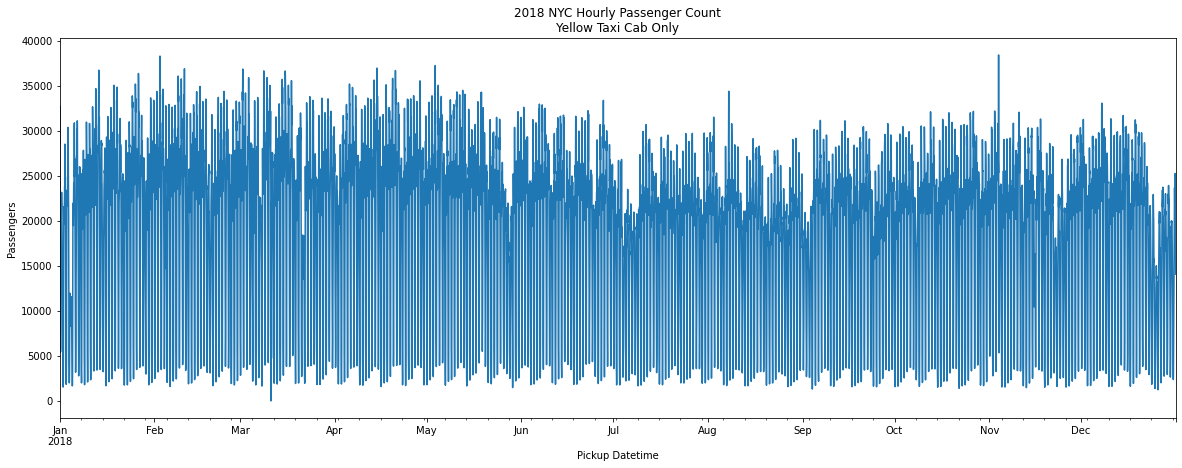

In [8]:
df.plot(figsize = (20,7), legend=None, title='2018 NYC Hourly Passenger Count\nYellow Taxi Cab Only')
plt.xlabel('Pickup Datetime')
plt.ylabel('Passengers')
plt.show()

## Matrix Profiles for respective window sizes

In [ ]:
"""
4 hours
8 hours
12 hours (Half of a day)
24 hours (A day)
168 hours (7 days)
720 hours (30 days)
"""

'\n4 hours\n8 hours\n12 hours (Half of a day)\n24 hours (A day)\n168 hours (7 days)\n720 hours (30 days)\n'

In [30]:
windows = [
  ('4 Hours', 4),
  ('8 Hours', 8),
  ('12 Hours', 12),
  ('24 Hours', 24),
  ('7 Days', 7 * 24),
  ('30 Days', 30 * 24),
]

profiles = {}

for label, window_size in windows:
  profile = mp.compute(df['passenger_count'].values, window_size)
  key = '{} Profile'.format(label)
  profiles[key] = profile

## Plotting matrix profiles for different window sizes

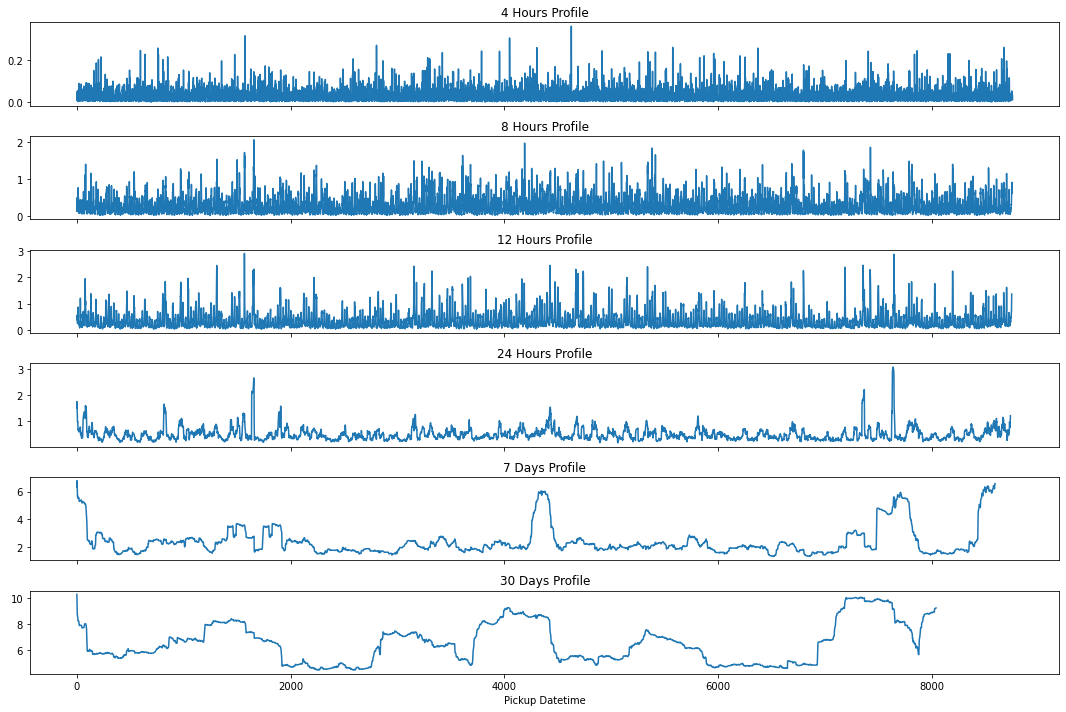

In [31]:
#Plot the signal data, as the window size changes the matrix profile changes
fig, axes = plt.subplots(6,1,sharex=True,figsize=(15,10))

for ax_idx, window in enumerate(windows):
  key = '{} Profile'.format(window[0])
  profile = profiles[key]
  axes[ax_idx].plot(profile['mp'])
  axes[ax_idx].set_title(key)

plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()

In [ ]:
"""
there are some obvious discords (peaks in the plot) within the 24 hour and 7 day windows, we will focus on those Matrix Profiles.
To extract the discords, we make use of the “top K discords” algorithm.
"""

'\nthere are some obvious discords (peaks in the plot) within the 24 hour and 7 day windows, we will focus on those Matrix Profiles.\nTo extract the discords, we make use of the “top K discords” algorithm.\n'

## Plotting Discords for top 5 anomalies

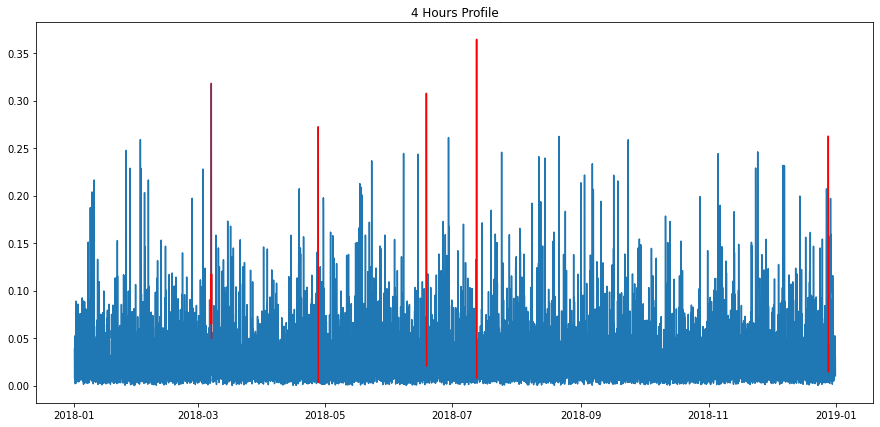

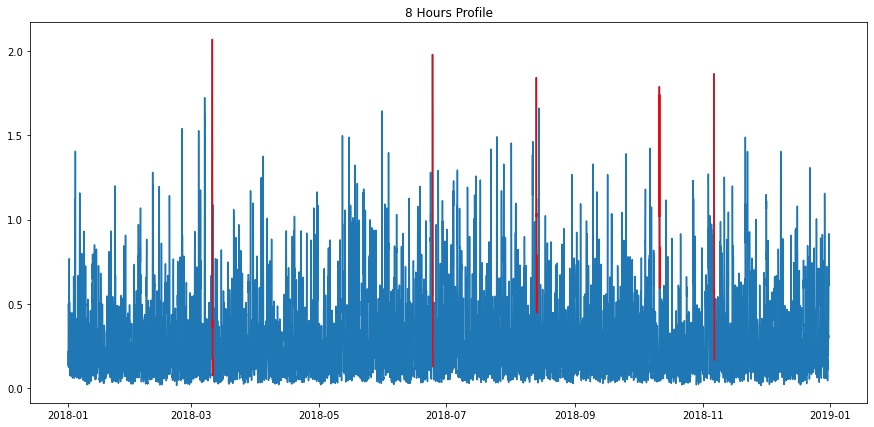

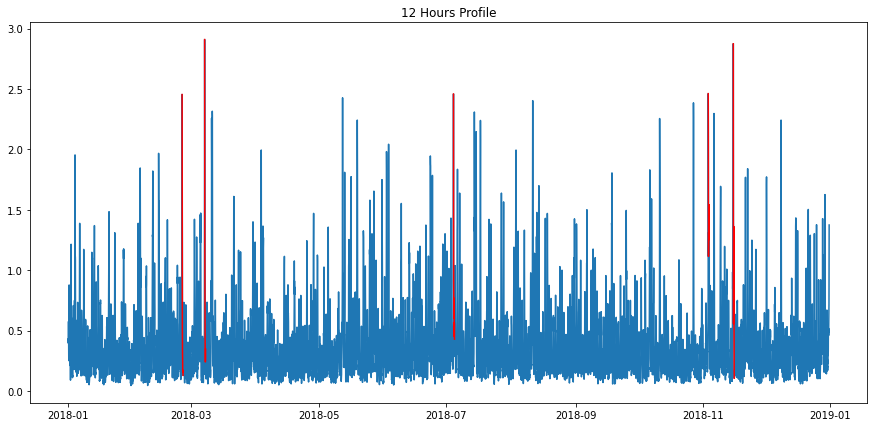

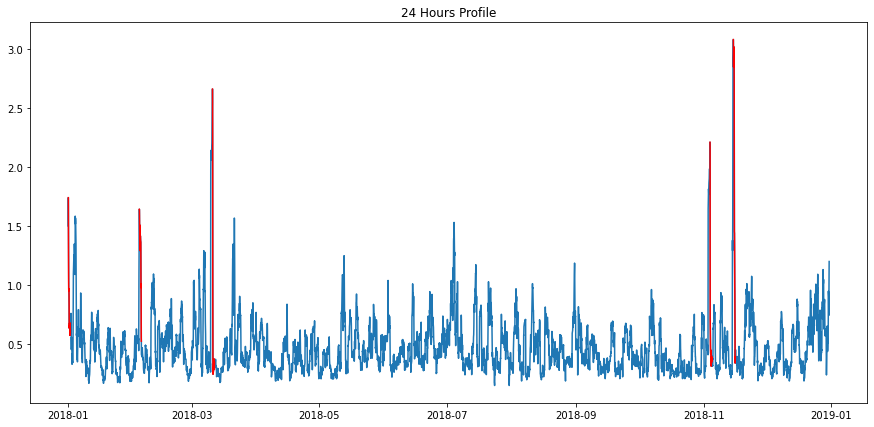

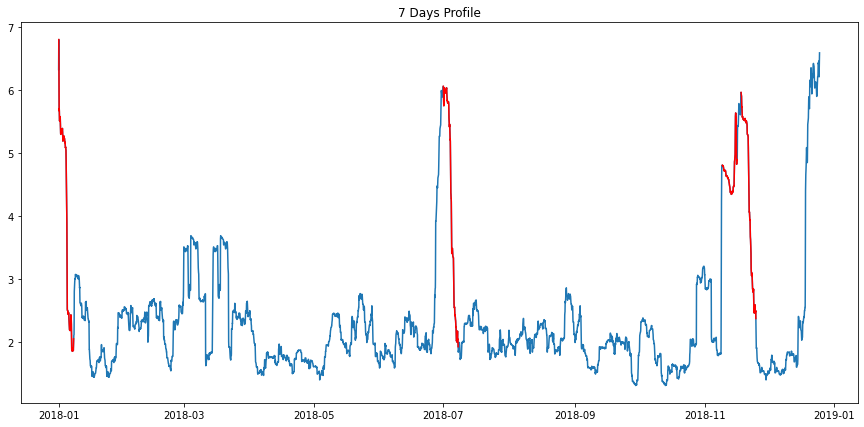

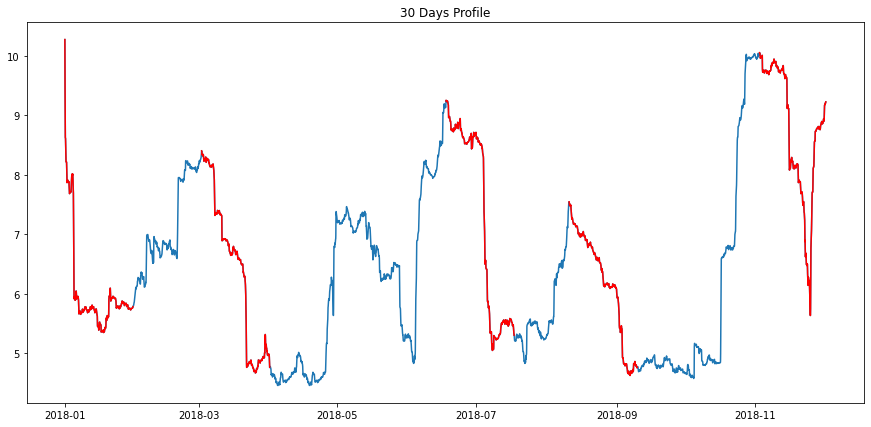

In [32]:
for label, window_size in windows:
  key = '{} Profile'.format(label)
  profiles[key] = mp.discover.discords(profiles[key], exclusion_zone = window_size, k=5)
  
  window_size = profiles[key]['w']
  mp_adjusted = np.append(profiles[key]['mp'], np.zeros(window_size - 1) + np.nan)
  #An exclusion zone is required to avoid matching on time periods that are very close to one another.
  
  plt.figure(figsize=(15, 7))
  ax = plt.plot(df.index.values, mp_adjusted)
  plt.title(key)
    
  for start_index in profiles[key]['discords']:
    x = df.index.values[start_index:start_index+window_size]
    y = mp_adjusted[start_index:start_index+window_size]
    plt.plot(x, y, c='r')
    
  plt.show()

## Analyzing 24 hrs discords

In [33]:
key = '24 Hours Profile'
profile = profiles[key]
window_size = profile['w']
mp_adjusted = np.append(profile['mp'], np.zeros(window_size - 1) + np.nan)
df['24 Hours Profile'] = mp_adjusted #matrix profiles for 24 hrs window_size
df

,passenger_count,24 Hours Profile
pickup_datetime,,
2018-01-01 00:00:00,28630,1.504145
2018-01-01 01:00:00,32778,1.743510
2018-01-01 02:00:00,27966,1.555468
2018-01-01 03:00:00,21243,1.285573
2018-01-01 04:00:00,14822,1.072544
...,...,...
2018-12-31 19:00:00,25264,NaN
2018-12-31 20:00:00,25106,NaN
2018-12-31 21:00:00,24315,NaN


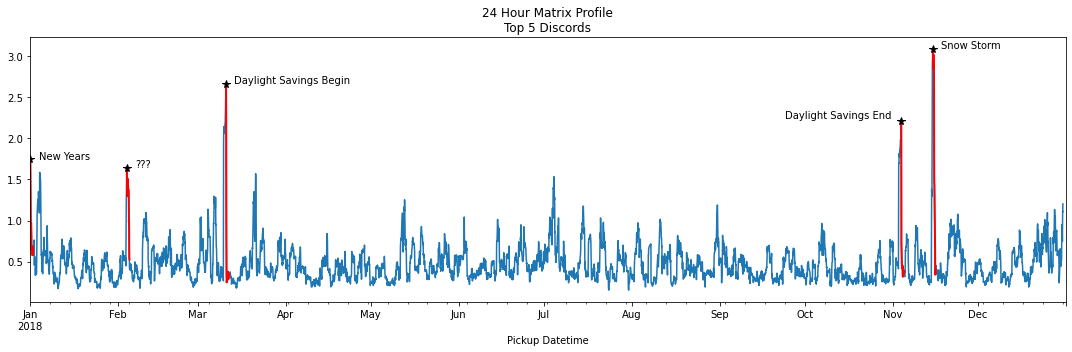

In [34]:
ax = df[key].plot(title='24 Hour Matrix Profile\nTop 5 Discords', figsize=(15,5))

for discord in profile['discords']:
  df.iloc[discord:discord+window_size][key].plot(ax=ax, c='r', lw='2')

df.iloc[profile['discords']][key].plot(kind='line', marker='*', c='black', markersize=8, ax=ax, lw=0)
plt.text('01-04-2018', 1.75, 'New Years', c='black')
plt.text('02-07-2018', 1.65, '???', c='black')
plt.text('03-14-2018', 2.675, 'Daylight Savings Begin', c='black')
plt.text('9-24-2018', 2.25, 'Daylight Savings End', c='black')
plt.text('11-18-2018', 3.1, 'Snow Storm', c='black')
plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()

In [38]:
key = '7 Days Profile'
profile = profiles[key]
window_size = profile['w']
mp_adjusted = np.append(profile['mp'], np.zeros(window_size - 1) + np.nan)
df[key] = mp_adjusted
df

,passenger_count,7 Days Profile
pickup_datetime,,
2018-01-01 00:00:00,28630,6.322826
2018-01-01 01:00:00,32778,6.645535
2018-01-01 02:00:00,27966,6.796680
2018-01-01 03:00:00,21243,6.496286
2018-01-01 04:00:00,14822,5.962622
...,...,...
2018-12-31 19:00:00,25264,NaN
2018-12-31 20:00:00,25106,NaN
2018-12-31 21:00:00,24315,NaN


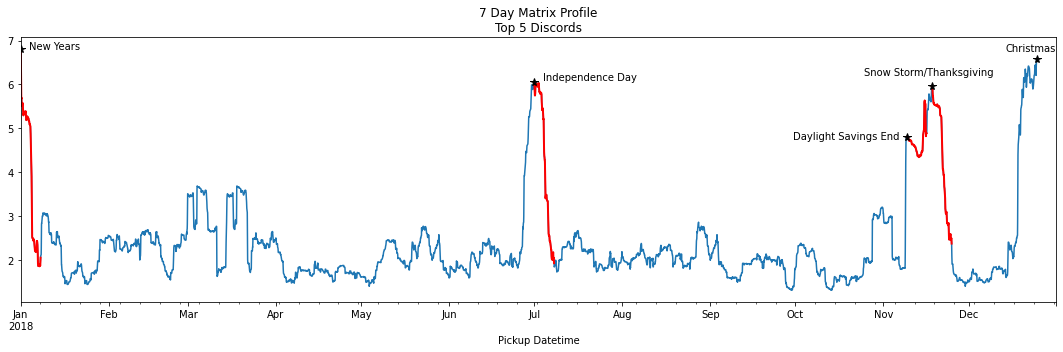

In [39]:
ax = df[key].plot(title='7 Day Matrix Profile\nTop 5 Discords', figsize=(15,5))

for discord in profile['discords']:
    df.iloc[discord:discord+window_size][key].plot(ax=ax, c='r', lw='2')

df.iloc[profile['discords']][key].plot(kind='line', marker='*', c='black', markersize=8, ax=ax, lw=0)
plt.text('01-04-2018', 6.8, 'New Years', c='black')
plt.text('07-04-2018', 6.1, 'Independence Day', c='black')
plt.text('9-30-2018', 4.75, 'Daylight Savings End', c='black')
plt.text('10-25-2018', 6.2, 'Snow Storm/Thanksgiving', c='black')
plt.text('12-14-2018', 6.75, 'Christmas', c='black')
plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()